This notebook is for code to generate graphs of square-sequences and plot them successively. Output from similar code is to be included in a Numberphile YouTube video.

Although it's a Jupyter notebook it uses Sage. You can get sage at `www.sagemath.org`. The original calculations were done on CoCalc, to which credit should also be given.

# The Question

Given a set of integers $1, 2, ..., n$, is it possible to re-order them so that every pair of consecutive integers (in the new order) add to a square number? For example, given a large enough $n$, $2$ could go between $7$ and $14$ because $2+7 = 9 = 3^2$ and $2+14 = 16 = 4^2$. However, $2$ could not appear next to $5$ as $2+5 =7$ is not a square number.

Note that the question asks whether it is possible to reorder the integers so that the whole set $1,2,..., n$ can be rearranged in this way; so even if it's possible to find 'neighbours' for $2$ in this sequence, we are asking whether it is possible to find 'neighbours' for every number (except the two ends).

*$*$NOTE:* This question appears in the "Just for Graphs" chapter of Matt Parker's book "Things to Make and Do in the Fourth Dimension". However, he doesn't give it a name, and I don't know of any other literature or names for this question. If you know a name or other literature, I (and Matt) would love to hear about it!

## This question can be attacked with graph theory

To check this property for a given $n$ (or, generalising, a given set of integers) we construct a graph where vertices are labelled with the integers and edges exist if an only if the two integers add to a square number. Asking whether we can reorder the integers is then equivalent to the existence of a Hamiltonian path on this graph. (A Hamiltonian path is one that passes through every vertex exactly once, but it does not necessarily need to be a Hamiltonian cycle.)

Sage allows us to construct graphs, check whether a given graph has a Hamiltonian path, and plot graphs in order to view the results, so we can use it to solve this problem for any given $n$.
This might allow some insights that help us to attack the problem in greater generality. Note that checking for the existence of a Hamiltonian path can be slow for large graphs.

# Constructing Graphs

In [1]:
def generate_square_pair_matrix(n):
    # For an integer n, constructs the adjacency matrix for the integers 1,..n.
    return Matrix(ZZ,[[i!=j and (i+j).is_square() for j in srange(1,n+1)] for i in srange(1,n+1)])
    
def generate_square_pair_graph(n):
    # Constructs the square-pair graph from the relevant matrix and relabels 
    # the vertices as 1,...,n instead of 0,...,n-1
    g = Graph(generate_square_pair_matrix(n))
    g.relabel(lambda x: x+1)
    return g

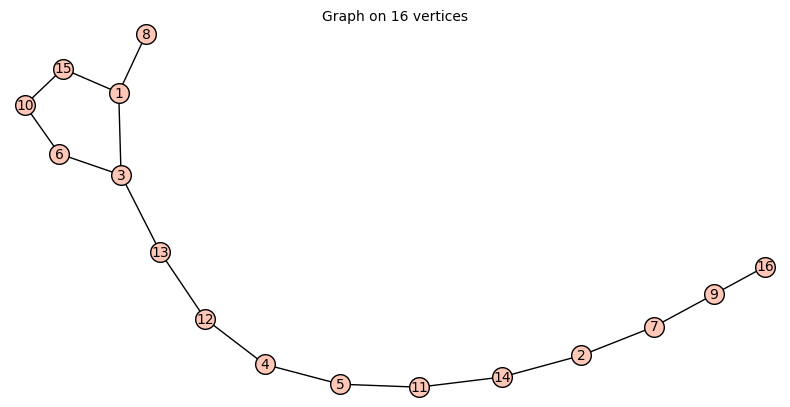

In [2]:
generate_square_pair_graph(16)

## Checking for Hamiltonian Paths

In [3]:
def check_square_pairs(n):
    # Given an integer n, generates the square-pair graph and its Hamiltonian path.
    # Note that if there is no Hamiltonian path hamiltonian_path() returns None.
    g = generate_square_pair_graph(n)
    hp = g.hamiltonian_path()
    return g, hp

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 82.6 ms
CPU times: user 12.7 s, sys: 24 ms, total: 12.7 s
Wall time: 12.9 s
CPU times: user 432 ms, sys: 8 ms, total: 440 ms
Wall time: 417 ms


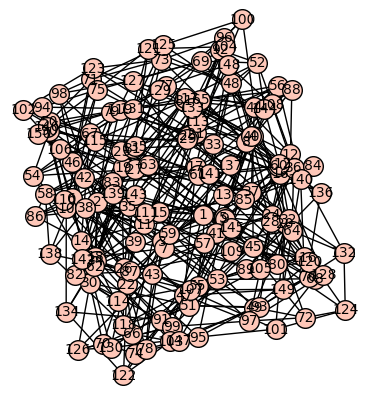

In [4]:
n = 150
%time g = generate_square_pair_graph(n)
%time h = g.hamiltonian_path()
%time g.plot()

This suggests indicates that finding the Hamiltonian path is the time-consuming part of this. Once we've found one, we should hang onto it!

## Storing Graphs and their Hamiltonian Paths

Eventually, we'll want to plot the graphs in such a way that the images build up - so that the positions for the vertices labelled integers $1,...,n$ will remain the same in the graph of $1,...n+1$ - then they can be animated to look like they're adding a vertex each time.

In order to do this, we will want to plot each graph (with Hamiltonian path, if one exists) one after the other and remember positions. Sage can do this! But it'll be easier if we can do all the plotting fairly soon after one another. As the Hamiltonian paths take time to compute and don't rely on one another, I propose that we do this, save the data, and then use it as an input to the plotting code.

I will use pickling to store the graphs and their Hamiltonian paths. Saving regularly will make sure effort is not wasted/data is not lost.

The key will be the number of vertices.
The value will be a pair of the graph itself and the subgraph of its Hamiltonian path

In [101]:
# Initialising: n=1 is a special case, we start by creating a file a dictionary with that one in
# Only run this the first time, otherwise you'll lose all your hard work!

# Treat n=1 as a special case, as hamiltonian_path() won't work here
temp_dict = {}
graph_with_one_vertex = Graph(1)
graph_with_one_vertex.relabel(lambda x: x+1)
temp_dict[1] = graph_with_one_vertex, None 


#Save the file
save(temp_dict,"sq_sum_graphs")

Having set up a file, we want to update the file up to a new maximum graph size.
We'll assume that the existing file doesn't have any gaps, and just add on to the top.

In [5]:
def update_graph_file(filename, max_graph_size, chunk_size):
    working_dict = load(filename)
    maxi = max(working_dict.keys())
    temp_dict = {}
    if max_graph_size > maxi:
        for i in range(maxi+1, max_graph_size+1):
            temp_dict[i] = check_square_pairs(i)
            if i % chunk_size == 0 or i == max_graph_size:
                working_dict = load(filename)
                working_dict.update(temp_dict)
                save(working_dict,filename)
                temp_dict = {}

In [85]:
update_graph_file("sq_sum_graphs",300,3)

## Generating images of graphs

Having generated some graphs, we want to plot them - this is for the video!

Will plot a graph, and highlight a Hamiltonian path where one exists. This function can take the position dictionary from a previous graph. It will remember and return the positions of the vertices for a graph so that they can be used to inform the next one.

In [92]:
def plot_graph(str_number,graph,ham_path,positions = None):
    #If there's no Hamiltonian path, using a graph with no edges and 
    #the correct vertices will do the trick
    if not ham_path:
        ham_path = Graph(graph.num_verts())
        ham_path.relabel(lambda x: x+1)

    degrees = ham_path.degree(labels = True)
    path_ends = [vertex for vertex, degree in degrees.iteritems() if degree == 1]
    
    return graph.plot(edge_color = '#d3d3d3', edge_style = '-', edge_colors = {'black': ham_path.edges()}, 
       vertex_colors = {'red':path_ends}, pos = positions, save_pos = True, edge_thickness = 4, transparent=True,
       title = str_number, title_pos = (0,1), figsize = [12,8], fig_tight= False), graph.get_pos()
        

In [96]:
# Clear out any old positions for these graphs

# This works around a bug(?) in Sage that I don't really understand, 
# but possibly has to do with the idea that a graph object has a 
# position that is a dictionary. 

# I've seen two issues that result.
# 1- If you plot for a second time without clearing positions, you'll
# end up with dummy vertices that do not belong to a given graph. (e.g. If last time you 
# graphed up to graph with 100 vertices, when you come back to plot the graph
# with 5 vertices will have 100 vertices showing, of which 95 will be unlabelled.)
#
# 2- If you pro-actively clear positions as you go, it seems as though it sort of
# breaks the layout, and we end up with a very narrow (?) plot. Maybe something about 
# remembering positions helps with the spring layout? 

# Anyway, this is a simple way to sort this out. Run it before you run the successive
# plots for all the graphs.
for my_graph in graphs.itervalues():
    my_graph[0].set_pos(None)

### Actual plotting

Here we do the plotting. We plot each graph successively so that they build up remembering where the vertices are from the graph before. Save the image files with a sensible filing system.

We assume that the pickled dictionary of graphs contains all successive graphs.

In [99]:
#Load in the dictionary of graphs
graphs = load("sq_sum_graphs")

#Choose a folder to put the images in
folder = "new_graph_images"

posns = None

for i in range(1,max(graphs.keys())+1):
    graph, hp = graphs[i]
    
    string_i = str(i)
    image, posns = plot_graph(string_i,graph,hp,posns)
    
    # This allows us to keep the images in the correct order
    # Hard-coded a 3 in there.
    padded_number = str(0)*(3-len(string_i)) + string_i
    filename = folder + "/image_"+padded_number+".png"
    
    image.save(filename)

## Considerations for further work

### Code
- Reconsider the use of a dictionary to store the graphs. Given that these are ordered, would a list be better? Note that we'd have an off-by-one issue to contend with.
- The slow part is the generation of Hamiltonian paths. How might we speed this up? Note that this is NP-complete.

### Mathematical
- This work can only check for square-sum sequences in a given case. It is conjectured (Matt Parker, Things to Make and Do in the Fourth Dimension, 2014. Chapter 9:  Just for Graphs) that this property holds for all integers greater than 25. Can this be proven?
- Looking at how the *number* of Hamiltonian paths varies might give us a clue.

### Sage
- I uncovered some oddness in the way Sage deals with graph plotting. I'd like to understand the intended behaviour better in order to either report a bug or fix my code to work better! These oddities are...
    - The graph with one vertex gets plotted in the middle of the image, but this isn't remembered when we come to plot the graph with two vertices.
    - The position of a graph is remembered in the graph object as a dictionary. It seems that this dictionary can (and in my code is!) updated. It says in the code that 'changes are cumulative' which leads to odd behaviour.
    - There seems to be some randomness in the way graphs are plotted and I don't know why.
    - Sometimes my images were looking very 'flat' and there was lots of empty space around the edges of the image. Why?